<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [51]:
import matplotlib.pyplot as plt

% matplotlib inline

In [52]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [53]:
boston = pd.concat([y, X], axis=1)

In [54]:
# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column
boston.isnull().sum()

MEDV       0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [55]:
boston.index

RangeIndex(start=0, stop=506, step=1)

In [56]:
boston.dtypes

MEDV       float64
CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object

In [57]:
boston.shape

(506, 14)

In [58]:
#summary statistics
boston.describe()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.532806,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,9.197104,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,5.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,17.025000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,21.200000,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,25.000000,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,50.000000,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [59]:
#the number of unique values for each column
boston.apply(lambda x: x.nunique())

MEDV       229
CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
dtype: int64

In [76]:
## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
#Score and plot your predictions. What do these results tell us?

feature_cols = ['CRIM', 'AGE', 'TAX', 'ZN']

X = boston[feature_cols]
y = boston.MEDV

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(X, y)

print(lr.intercept_)
print(lr.coef_)


29.844353994885854
[-0.17269639 -0.02035122 -0.01522181  0.08085216]


In [74]:
#+29.8 = the intercept (MEDV) when variables are at 0.  

#-0.17 = Per capita crime rate increases 1 and MEDV decreases 0.17
#-0.02 = Proportion of owner-occupied units built prior to 1940 increases 1 and MEDV decreases 0.02
#-0.01 = Full-value property-tax rate per $10,000 increases 1 and MEDV decreases 0.01
#+0.08 = Proportion of residential land zoned for lots over 25,000 sq.ft. increases 1 and MEDV increases 0.08

#MEDV is in 1000's     1 = 1000

/Users/User/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


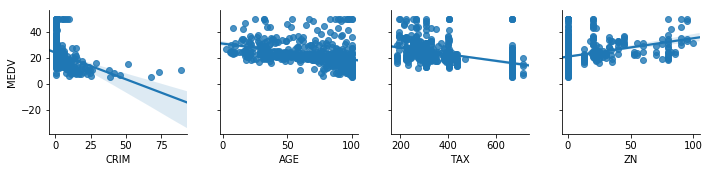

In [77]:
import seaborn as sns

sns.pairplot(boston, x_vars=feature_cols, y_vars='MEDV', kind='reg');

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [78]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=99)

# Before splitting
print(X.shape)

# After splitting
print(X_train.shape)
print(X_test.shape)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(metrics.mean_squared_error(y_train, lr.predict(X_train)))
print(metrics.mean_squared_error(y_test, y_pred))

(506, 4)
(354, 4)
(152, 4)
59.86351327107652
60.256851356470726


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=99)

# Before splitting
print(X.shape)

# After splitting
print(X_train.shape)
print(X_test.shape)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(metrics.mean_squared_error(y_train, lr.predict(X_train)))
print(metrics.mean_squared_error(y_test, y_pred))

(506, 4)
(455, 4)
(51, 4)
62.32655051592882
38.51289034458308


In [68]:
# shows that using the larger training sample (90%) in this case produces a better model (lower mean sq error) 
# on the test sample (10%)   38.5  vs  60.2 MSE    

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [92]:
from sklearn import model_selection

kf = model_selection.KFold(n_splits=5, shuffle=True)

mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION 5 FOLDS~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 60.91664744972752
R2: 0.28960715723605623

Model 2
MSE: 52.14940712954387
R2: 0.28865363787714116

Model 3
MSE: 53.24055155752043
R2: 0.28811241747004523

Model 4
MSE: 84.43982115592438
R2: 0.2896921180997898

Model 5
MSE: 53.80614549809125
R2: 0.2890569137115456

~~~~ SUMMARY OF CROSS VALIDATION 5 FOLDS~~~~
Mean of MSE for all folds: 60.910514558161495
Mean of R2 for all folds: 0.2890244488789156


In [93]:
from sklearn import model_selection

kf = model_selection.KFold(n_splits=6, shuffle=True)

mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION 6 FOLDS~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 55.85092782477431
R2: 0.28791642109550886

Model 2
MSE: 88.83289178346574
R2: 0.2891090899673042

Model 3
MSE: 43.760684054891605
R2: 0.2890965529323617

Model 4
MSE: 66.70175739206951
R2: 0.28881041018572295

Model 5
MSE: 67.87341237564681
R2: 0.28597674675721485

Model 6
MSE: 47.02956022762852
R2: 0.28943791100059146

~~~~ SUMMARY OF CROSS VALIDATION 6 FOLDS~~~~
Mean of MSE for all folds: 61.67487227641275
Mean of R2 for all folds: 0.2883911886564507


In [94]:
from sklearn import model_selection

kf = model_selection.KFold(n_splits=7, shuffle=True)

mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION 7 FOLDS~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 86.73369079203458
R2: 0.28915668911143666

Model 2
MSE: 90.00773824711791
R2: 0.2894411129842004

Model 3
MSE: 41.57800812878017
R2: 0.28918123899347525

Model 4
MSE: 45.99155039757324
R2: 0.28885351372700396

Model 5
MSE: 54.450419200085825
R2: 0.288067779951522

Model 6
MSE: 55.473258595057324
R2: 0.2894113203710318

Model 7
MSE: 54.238256306446026
R2: 0.28926659202625815

~~~~ SUMMARY OF CROSS VALIDATION 7 FOLDS~~~~
Mean of MSE for all folds: 61.210417381013585
Mean of R2 for all folds: 0.2890540353092755


In [95]:
from sklearn import model_selection

kf = model_selection.KFold(n_splits=8, shuffle=True)

mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION 8 FOLDS~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 62.82371447126089
R2: 0.2888746438128822

Model 2
MSE: 75.79234389312353
R2: 0.2899825390868328

Model 3
MSE: 68.08226338098363
R2: 0.2882563800596992

Model 4
MSE: 86.84476022031164
R2: 0.2895884454176548

Model 5
MSE: 40.774680737782305
R2: 0.2898954396671646

Model 6
MSE: 47.094665491046335
R2: 0.28951768284447077

Model 7
MSE: 59.7245017113961
R2: 0.2895376895564358

Model 8
MSE: 46.96549490316356
R2: 0.2898612257277027

~~~~ SUMMARY OF CROSS VALIDATION 8 FOLDS~~~~
Mean of MSE for all folds: 61.0128031011335
Mean of R2 for all folds: 0.28943925577160534


In [96]:
from sklearn import model_selection

kf = model_selection.KFold(n_splits=9, shuffle=True)

mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION 9 FOLDS~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 46.706151640839884
R2: 0.2900029423413525

Model 2
MSE: 64.40368976178145
R2: 0.29017107141436727

Model 3
MSE: 64.7719627126393
R2: 0.28951967688154867

Model 4
MSE: 44.066930670271525
R2: 0.2897206168191804

Model 5
MSE: 66.75402844505676
R2: 0.28964628402178283

Model 6
MSE: 32.41274265339462
R2: 0.289973065509612

Model 7
MSE: 67.63327680549791
R2: 0.2895329271722463

Model 8
MSE: 114.93153185233028
R2: 0.2870661484353849

Model 9
MSE: 49.51592982694503
R2: 0.28915888350167207

~~~~ SUMMARY OF CROSS VALIDATION 9 FOLDS~~~~
Mean of MSE for all folds: 61.24402715208409
Mean of R2 for all folds: 0.2894212906774608


In [97]:

kf = model_selection.KFold(n_splits=10, shuffle=True)

mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION 10 FOLDS~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 64.32517518528846
R2: 0.29006812366047297

Model 2
MSE: 37.63810092593695
R2: 0.2895782738638868

Model 3
MSE: 59.32591352188301
R2: 0.2901706091252898

Model 4
MSE: 74.83718803638146
R2: 0.2898632151771473

Model 5
MSE: 32.12759224313762
R2: 0.2894808860896204

Model 6
MSE: 78.71509858051267
R2: 0.2894510785780562

Model 7
MSE: 75.63511274102437
R2: 0.2895248747266743

Model 8
MSE: 64.44816820148432
R2: 0.2898688607004274

Model 9
MSE: 70.58486111886317
R2: 0.2878771259902677

Model 10
MSE: 53.190183378138535
R2: 0.2902198832310545

~~~~ SUMMARY OF CROSS VALIDATION 10 FOLDS~~~~
Mean of MSE for all folds: 61.08273939326506
Mean of R2 for all folds: 0.28961029311428976


#    #   do up to here for basic version

# KNN Practice

In [98]:
# Read the iris data into a DataFrame
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [99]:
iris.head()

# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

In [100]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

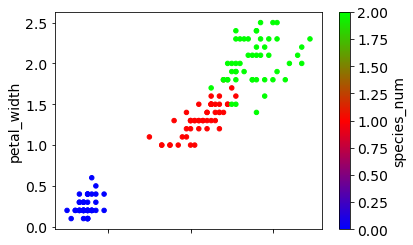

In [101]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'
iris['species_num'] = iris.species.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})

# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
iris.plot(kind='scatter', x='petal_length', y='petal_width', c='species_num', colormap='brg');

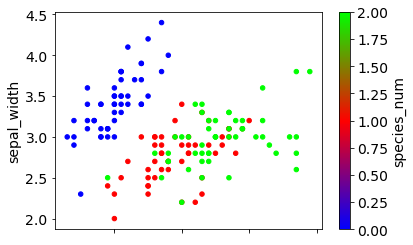

In [102]:
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES

iris.plot(kind='scatter', x='sepal_length', y='sepal_width', c='species_num', colormap='brg');

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [103]:
feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = iris[feature_cols]

### Create your target vector "y"
This will be the species type.

In [104]:
y = iris.species

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)


### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [106]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [107]:
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

0.9210526315789473


### Create a Model With Five Neighbors. Did it Improve?

In [108]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

0.9210526315789473


In [ ]:
# it did not go up when inceased from 1 to 5...  

### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [109]:
scores = []
for k in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X,y)
    pred = knn.predict(X)
    score = float(sum(pred == y)) / len(y)
    scores.append([k, score])

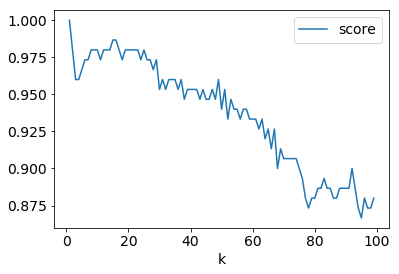

In [110]:
data = pd.DataFrame(scores,columns=['k','score'])
data.plot.line(x='k',y='score');

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

In [ ]:
# Return probability estimates for the test data set called X_new

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [111]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

AttributeError: 'DataFrame' object has no attribute 'data'

In [ ]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

In [ ]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X);

In [ ]:
# Check out Pearson scores


## Demo: Patsy

In [ ]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [ ]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [ ]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))